In [ ]:
#First trial of ML to find radial velocities. Goal is to use regression to extrapolate the velocities. 

In [1]:
import pandas as pd
import numpy as np

In [2]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

In [3]:
# These are just my choices to make the plots look nice
plt.rcParams.update({'font.family':'cmr10','font.size': 13})
matplotlib.rcParams['axes.unicode_minus']=False
matplotlib.rcParams['axes.labelsize']=15
plt.rcParams['figure.figsize']=(4,4)
plt.rcParams['figure.dpi'] = 80
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

In [4]:
SimulatedStars = pd.read_csv('rave_tgas_cleaned_data.csv',index_col=None)

In [5]:
SimulatedStars.head()

,Unnamed: 0,ra,dec,b,l,logg,teff,gband,vr,vtheta,...,pmde_err,vU,vV,vW,vU_err,vV_err,vW_err,jband,kband,R_cyl
0,0,160.760542,-13.241389,39.009388,261.198041,4.02,6047.5,11.154045,-22.767779,-8.553811,...,1.109520,2.989305,-26.186428,0.468133,7.397238,2.740294,3.563465,10.313,9.981,8.059333
1,1,160.258125,-13.640972,38.394644,261.014525,1.92,4777.9,10.940921,-90.714933,13.228575,...,1.039390,59.797612,-69.816238,-28.596837,21.613296,8.263897,9.739697,9.513,8.868,8.191753
2,2,159.117958,-13.938889,37.476591,260.143047,3.76,5684.4,9.964015,17.192325,-17.679071,...,0.630677,-32.337603,-30.413529,10.738150,2.762826,0.893481,1.207606,9.107,8.738,8.030682
3,3,159.159667,-13.473472,37.865498,259.816167,3.75,5896.4,9.740564,-19.469996,-8.870117,...,0.576193,4.840963,-15.400051,1.330989,1.266904,0.713310,0.745443,8.843,8.585,8.024455
4,4,160.152417,-11.347833,40.129253,259.072345,2.50,4867.2,10.547413,3.542314,-11.618539,...,0.690997,-31.966993,-30.385995,4.604890,10.842726,1.868670,4.019525,9.129,8.482,8.166834


In [6]:
SimulatedStars.columns

Index(['Unnamed: 0', 'ra', 'dec', 'b', 'l', 'logg', 'teff', 'gband', 'vr',
       'vtheta', 'vphi', 'vr_err', 'vphi_err', 'vtheta_err', 'z', 'z_err',
       'distance', 'distance_err', 'R', 'feH', 'ID', 'hrv', 'hrv_err', 'pmra',
       'pmra_err', 'pmde', 'pmde_err', 'vU', 'vV', 'vW', 'vU_err', 'vV_err',
       'vW_err', 'jband', 'kband', 'R_cyl'],
      dtype='object')

In [7]:
SimulatedStars.shape

(164387, 36)

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [9]:
# What columns to use?
use_cols = ['l', 'b','distance','pmra','pmde']
# Make the design matrix
X = SimulatedStars[use_cols].values
Y = (SimulatedStars['vr']).values

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, Y,
                                                    test_size = 0.2,
                                                    random_state=42)

In [11]:
print(X_train.shape)
print(y_train.shape)
print('There are {0} stars in the training set'.format(np.sum(y_train)))
print()
print(X_test.shape)
print(y_test.shape)
print('There are {0} stars in the test set'.format(np.sum(y_test)))

(131509, 5)
(131509,)
There are 40356.09328778812 stars in the training set

(32878, 5)
(32878,)
There are 6386.546530267198 stars in the test set


In [12]:
# Might need to add in a data preprocessing step here 
#Either reweighting the radial velocity or training set features have 0 mean and unit variance

In [13]:
SS = StandardScaler()
X_train = SS.fit_transform(X_train)

In [14]:
# Now scale the test data using the same mean and standard deviation as found with the training data
X_test = SS.transform(X_test)

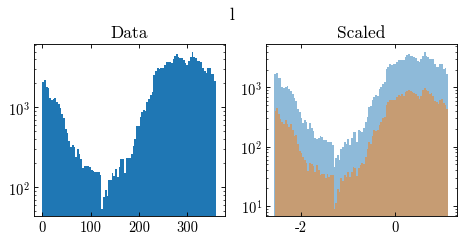

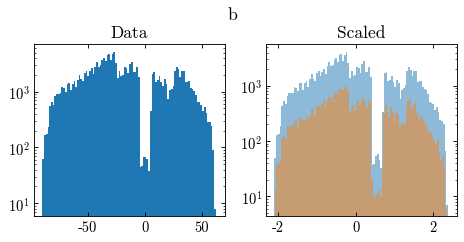

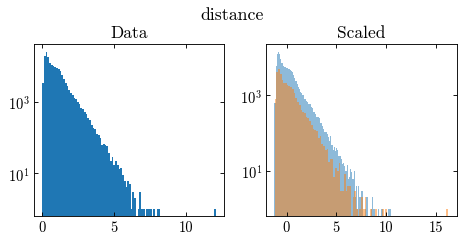

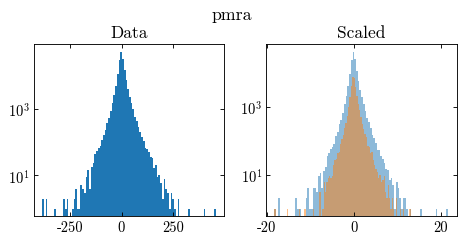

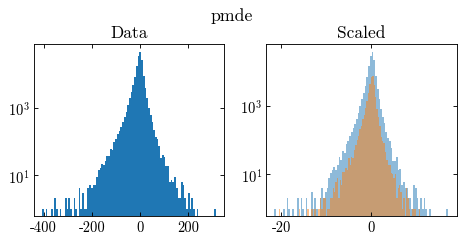

In [15]:
#visualize check data
for i, col in enumerate(use_cols):
    plt.figure(figsize=(6, 3))
    plt.subplot(1,2,1)
    plt.hist(SimulatedStars[col], bins=100)
    plt.yscale('log')
    plt.title('Data')
    
    plt.subplot(1,2,2)
    plt.hist(X_train[:, i], bins=100, alpha=0.5)
    plt.hist(X_test[:, i], bins=100, alpha=0.5)
    plt.yscale('log')
    plt.title('Scaled')
    
    plt.suptitle(col, y=1.01, fontsize=16)
    
    plt.tight_layout()

In [16]:
#Building Classifier 

In [17]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam

Using TensorFlow backend.


In [18]:
from keras import backend as K

In [19]:
def LikelihoodLossFunction(y_true, y_pred):
    # shape of y_pred should be (nsamples, 2)
    # the first column should be the mean of the prediction
    # the second column is the confidence (number of standard deviations)
#     print y_true.shape
#     print y_pred.shape
    SIGMA = K.abs(y_pred[:, 1])
    LOC = y_pred[:, 0]
    X = y_true[:, 0]
    
    ARG = K.square(X - LOC) / (2 * K.square(SIGMA))
    PREFACT = K.log(K.pow(2 * np.pi * K.square(SIGMA), -0.5))
    #you get this from the conditional probability distribution
    return K.mean(ARG - PREFACT)
    #return K.mean(ARG)
#now i'm wondering if somewhere in here I should return SIGMA

In [20]:
MyModel = Sequential()
MyModel.add(Dense(units=100, activation='relu', input_dim=X_train.shape[1]))
MyModel.add(Dense(units=100, activation='relu'))
MyModel.add(Dense(units=100, activation='relu'))
MyModel.add(Dense(units=2))
#using tanh activation function in the last layer
#MyModel.compile(loss='mean_squared_error',
       #         optimizer='adam'
       #       )
MyModel.compile(loss=LikelihoodLossFunction,
                optimizer='adam'
               )

In [21]:
MyModel.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               600       
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 202       
Total params: 21,002
Trainable params: 21,002
Non-trainable params: 0
_________________________________________________________________


In [22]:
#training any checkpoint or early stopping? 
es = EarlyStopping(patience=2, restore_best_weights=True)

In [23]:
print(y_train.shape[0])

131509


In [ ]:
history = MyModel.fit(X_train,np.vstack([y_train,
                                  np.ones(y_train.shape[0])
                                  ]).T,
                      validation_split=0.2,
                      epochs=100,
                      batch_size=1000,
                      callbacks = [es]
                     )
#I think in adding the second column to the y_training values that is all 1s can give us an estimate of the error...

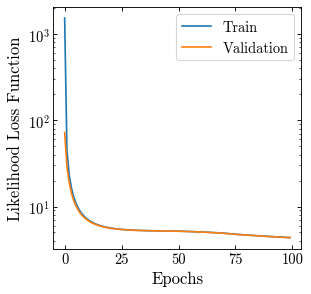

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Likelihood Loss Function')
plt.legend(['Train', 'Validation'])
plt.show()

In [40]:
# predict the scores for the test set, then histogram them based on the real labels
test_preds = MyModel.predict(X_test)
print(test_preds[1:100,1])

[26.249117  10.287292  26.916237  10.989655  15.5164385  7.897994
  7.416284  19.080153  11.531479  14.264751  28.718893  16.854305
 33.725967  10.906939  52.767174  40.493923  21.112045  29.25055
 14.939514   6.3738856 22.354023  12.653101  28.437351  12.276075
 21.256884  11.002588  21.904957  26.266773  31.46113   18.873022
 12.229948  13.584927  16.577135  63.04116   10.912963  17.694294
 13.017574   6.7127643  9.393139  42.4619    24.98759   14.50415
 29.385406   9.13755   24.494053  23.608963   9.731483  27.827934
 23.087917  14.346045  11.705294  18.541885   9.286823  24.63631
 22.419971  12.33768   12.60079   11.558702  11.948791  11.39385
 19.885353  19.560493  10.044912  18.712929  14.4967    10.145316
 11.987534  18.198673  12.409182  24.080315  13.458553  31.851181
 46.838657  19.801334  17.57246   15.640736  23.55835   17.931286
  9.154191  10.864804   7.8608875 28.571835  19.299774  20.92688
 15.225779  22.398912  11.664635  13.805716   8.235456  10.238895
 18.686953  24.

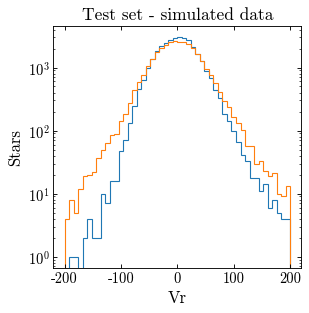

In [41]:
plt.hist(test_preds[:,0], bins=50, range=(-200,200), histtype='step')
plt.hist(y_test, bins=50, range=(-200,200), histtype='step')
plt.xlabel('Vr')
plt.ylabel('Stars')
plt.title('Test set - simulated data')
plt.yscale('log')
plt.show()


Plotting some of the predicted points with confidence as the errorbars 

[26.249117  10.287292  26.916237  10.989655  15.5164385  7.897994
  7.416284  19.080153  11.531479  14.264751  28.718893  16.854305
 33.725967  10.906939  52.767174  40.493923  21.112045  29.25055
 14.939514   6.3738856 22.354023  12.653101  28.437351  12.276075
 21.256884  11.002588  21.904957  26.266773  31.46113   18.873022
 12.229948  13.584927  16.577135  63.04116   10.912963  17.694294
 13.017574   6.7127643  9.393139  42.4619    24.98759   14.50415
 29.385406   9.13755   24.494053  23.608963   9.731483  27.827934
 23.087917 ]


Text(0, 0.5, 'Vr predicted')

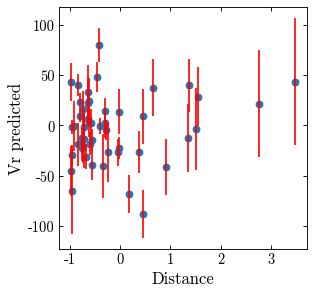

In [50]:
#test_preds[:,1] = (test_preds[:,1] - np.min(test_preds[:,1]))/(np.max(test_preds[:,1])- np.min(test_preds[:,1]))
#trying to manually rescale confidence
print(test_preds[1:50,1])
plt.scatter(X_test[1:50,2], test_preds[1:50,0])
plt.errorbar(X_test[1:50,2], test_preds[1:50,0], yerr = test_preds[1:50,1], color = 'red',ls='none')
plt.xlabel('Distance')
plt.ylabel('Vr predicted')
#maybe good idea to bootstrap bc seems to have differing results for different times that I run it

Text(0, 0.5, 'Vr real')

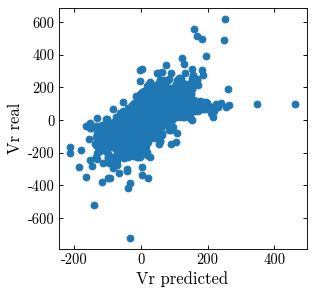

In [48]:
plt.scatter(test_preds[:,0],y_test)
plt.xlabel('Vr predicted')
plt.ylabel('Vr real')

In [30]:
def ConstantLikelihoodFunction(y_true, y_pred):
    # shape of y_pred should be (nsamples, 2)
    # the first column should be the mean of the prediction
    # the second column is the confidence (number of standard deviations)
#     print y_true.shape
#     print y_pred.shape
    LOC = y_pred[:, 0]
    X = y_true[:, 0]
    ARG = -K.square(X - LOC) / (2.0)
    return K.mean(-ARG)

Going to Try Calculating the Mean and Error from two different networks...although I'm not sure how this will give us the error on the network that calculates the mean...unless we can somehow transfer over the information from the weights

In [68]:
from keras.layers import Input, Dense, Lambda, Concatenate
from keras.models import Model
from keras.utils import plot_model

In [71]:
# del(inputs, MeanEst, MeanModel, ConfEst, ConfModel)
inputs = Input(shape=(5,))
MeanEst = Dense(100, activation='tanh')(inputs)
MeanEst = Dense(100, activation='tanh')(MeanEst)
MeanEst = Dense(100, activation='tanh')(MeanEst)
MeanEst = Dense(1, activation='linear')(MeanEst)
MeanModel = Model(inputs=[inputs], outputs=MeanEst)

ConfEst = Dense(100, activation='tanh')(inputs)
ConfEst = Dense(100, activation='tanh')(ConfEst)
ConfEst = Dense(100, activation='tanh')(ConfEst)
ConfEst = Dense(1, activation='relu')(ConfEst)
ConfModel = Model(inputs=[inputs], outputs=ConfEst)
#this can't possibly give me a confidence output? the only thing that appears to define a confidence is the relu
#on the last layer 
CombinedSub = Concatenate(axis=-1)([MeanModel(inputs), ConfModel(inputs)])
CombinedModel = Model(inputs=inputs, outputs=CombinedSub)
#plot_model(CombinedModel,to_file='demo.png',show_shapes=True)

In [63]:
CombinedModel.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 5)            0                                            
__________________________________________________________________________________________________
model_9 (Model)                 (None, 1)            20901       input_3[0][0]                    
__________________________________________________________________________________________________
model_10 (Model)                (None, 1)            20901       input_3[0][0]                    
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 2)            0           model_9[1][0]                    
                                                                 model_10[1][0]            

In [72]:
ConfModel.trainable = False
MeanModel.trainable = True
CombinedModel.compile(loss=LikelihoodLossFunction,
                      optimizer='adam'
                     )

CombinedModel.fit(X_train,y_train,
                  epochs=100,
                  batch_size=1000,
                  validation_split=0.2
                 )

Train on 105207 samples, validate on 26302 samples
Epoch 1/100
105207/105207 [==============================] - 1s 9us/step - loss: nan - val_loss: nan
Epoch 2/100
105207/105207 [==============================] - 1s 7us/step - loss: nan - val_loss: nan
Epoch 3/100
105207/105207 [==============================] - 1s 7us/step - loss: nan - val_loss: nan
Epoch 4/100
105207/105207 [==============================] - 1s 7us/step - loss: nan - val_loss: nan
Epoch 5/100
105207/105207 [==============================] - 1s 7us/step - loss: nan - val_loss: nan
Epoch 6/100
105207/105207 [==============================] - 1s 7us/step - loss: nan - val_loss: nan
Epoch 7/100
 55000/105207 [==============>...............] - ETA: 0s - loss: nan

KeyboardInterrupt: 

In [ ]:
ConfModel.trainable = True
MeanModel.trainable = False
CombinedModel.compile(loss=LikelihhodLossFunction,
                      optimizer='adam'
                     )

CombinedModel.fit(X_train,np.vstack([y_train,
                                  np.ones(y_train.shape[0])
                                  ]).T,
                  epochs=500,
                  batch_size=1000,
                  validation_split=0.1,
                  verbose=0
                 )